In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 16
BLOCK_SIZE = 3
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def get_data(path):
  data = pd.read_csv(path).drop(labels=['Y'], axis=1)
  labels = pd.read_csv(path)['Y']
  data = torch.tensor(data.values)[:, 1::].float()
  data = ((data - data.mean()) / data.std())
  labels = torch.tensor(labels.values).float()
  return data, labels

In [5]:
train_data, train_labels = get_data("train_data.csv")
test_data, test_labels   = get_data("test_data.csv")

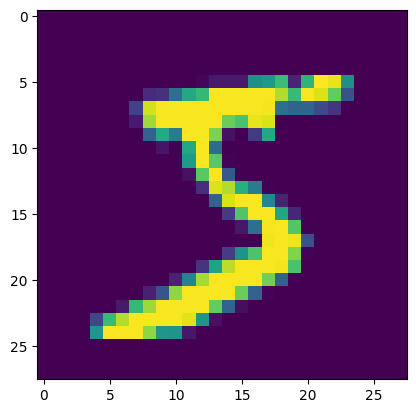

In [6]:
plt.imshow(train_data[0].view((28, 28)))

In [7]:
class MnistData(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return (self.x[idx], self.y[idx])

In [8]:
train_data = DataLoader(MnistData(train_data, train_labels), BATCH_SIZE, shuffle=True)
test_data  = DataLoader(MnistData(test_data,   test_labels), BATCH_SIZE, shuffle=True)

In [17]:
class ANN(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(784, 512)
    self.b1 = nn.BatchNorm1d(512)
    self.l2 = nn.Linear(512, 128)
    self.b2 = nn.BatchNorm1d(128)
    self.l3 = nn.Linear(128, 10)
    self.b3 = nn.BatchNorm1d(10)

  def forward(self, x):
    o1 = F.relu(self.b1(self.l1(x)))
    o2 = F.relu(self.b2(self.l2(o1)))
    o3 = F.relu(self.b3(self.l3(o2)))

    return o3

In [26]:
class DeepNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1  = nn.Sequential(nn.Linear(784,  700),  nn.BatchNorm1d(700),  nn.ReLU())
    self.l2  = nn.Sequential(nn.Linear(700,  650),  nn.BatchNorm1d(650),  nn.ReLU())
    self.l3  = nn.Sequential(nn.Linear(650,  600),  nn.BatchNorm1d(600),  nn.ReLU())
    self.l4  = nn.Sequential(nn.Linear(600,  550),  nn.BatchNorm1d(550),  nn.ReLU())
    self.l5  = nn.Sequential(nn.Linear(550,  500),  nn.BatchNorm1d(500),  nn.ReLU())
    self.l6  = nn.Sequential(nn.Linear(500,  450),  nn.BatchNorm1d(450),  nn.ReLU())
    self.l7  = nn.Sequential(nn.Linear(450,  400),  nn.BatchNorm1d(400),  nn.ReLU())
    self.l8  = nn.Sequential(nn.Linear(400,  350),  nn.BatchNorm1d(350),  nn.ReLU())
    self.l9  = nn.Sequential(nn.Linear(350,  300),  nn.BatchNorm1d(300),  nn.ReLU())
    self.l10 = nn.Sequential(nn.Linear(300,  250),  nn.BatchNorm1d(250),  nn.ReLU())
    self.l11 = nn.Sequential(nn.Linear(250,  200),  nn.BatchNorm1d(200),  nn.ReLU())
    self.l12 = nn.Sequential(nn.Linear(200,  150),  nn.BatchNorm1d(150),  nn.ReLU())
    self.l13 = nn.Sequential(nn.Linear(150,  100),  nn.BatchNorm1d(100),  nn.ReLU())
    self.l14 = nn.Sequential(nn.Linear(100,   50),  nn.BatchNorm1d(50),   nn.ReLU())
    self.l15 = nn.Sequential(nn.Linear(50,    32),  nn.BatchNorm1d(32),   nn.ReLU())
    self.l16 = nn.Sequential(nn.Linear(32,    16),  nn.BatchNorm1d(16),   nn.ReLU())
    self.l17 = nn.Sequential(nn.Linear(16,    10),  nn.BatchNorm1d(10),   nn.ReLU())

    self.full = nn.Sequential(
      self.l1, self.l2, self.l3, self.l4, self.l5, self.l6, self.l7, self.l8,
      self.l9, self.l10, self.l11, self.l12, self.l13, self.l14, self.l15,
      self.l16, self.l17
    )


  def forward(self, x):
    return self.full(x)

In [67]:
class Block(nn.Module):
  def __init__(self, d0, d1, d2, d3):
    super().__init__()
    self.full = nn.Sequential(
        nn.Linear(d0, d1), nn.BatchNorm1d(d1), nn.ReLU(),
        nn.Linear(d1, d2), nn.BatchNorm1d(d2), nn.ReLU(),
        nn.Linear(d2, d3), nn.BatchNorm1d(d3), nn.ReLU()
    )

  def forward(self, x):
    return self.full(x)


class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(784, 700)
    self.b1 = Block(700, 650, 600, 550)
    self.b2 = Block(550, 500, 450, 400)
    self.b3 = Block(400, 350, 300, 250)
    self.b4 = Block(250, 200, 150, 100)
    self.b5 = Block(100,  64,  32,  16)
    self.l2 = nn.Linear(16, 10)

  def forward(self, x):
    o1 = self.l1(x)
    o2 = self.b1(o1 +  x[:, 42:-42])
    o3 = self.b2(o2 + o1[:, 75:-75])
    o4 = self.b3(o3 + o2[:, 75:-75])
    o5 = self.b4(o4 + o3[:, 75:-75])
    o6 = self.b5(o5 + o4[:, 75:-75])
    output = self.l2(o6)

    return output

In [69]:
def train_epoch(data, model, optim):
  lossi = []
  for x, y in data:
    x = x.to(DEVICE)
    y = y.type(torch.LongTensor)
    y = y.to(DEVICE)

    output = model(x.float())
    loss = F.cross_entropy(output, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    lossi.append(loss.item())

  return torch.tensor(lossi).mean()


def test_epoch(data, model):
  lossi = []
  for x, y in data:
    x = x.to(DEVICE)
    y = y.type(torch.LongTensor)
    y = y.to(DEVICE)

    output = model(x.float())
    loss = F.cross_entropy(output, y)

    lossi.append(loss.item())

  return torch.tensor(lossi).mean()

In [72]:
def train(train_data, test_data, model, optim):
  train_lossi, test_lossi = [], []
  for epoch in range(EPOCHS):
    train_lossi.append(train_epoch(train_data, model, optim))
    test_lossi.append(test_epoch(test_data, model))

    print(f"EPOCH: {epoch}  |  TRAIN_LOSS: {train_lossi[-1]}  |  TEST_LOSS: {test_lossi[-1]}")

  return train_lossi, test_lossi

In [73]:
model = ANN().to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)
train_loss_ann, test_loss_ann = train(train_data, test_data, model, optim)
print(f"-------------------ANN TRAINING COMPLETE-------------------\n\n")

model = DeepNet().to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)
train_loss_deep, test_loss_deep = train(train_data, test_data, model, optim)
print(f"-------------------DEEPNET TRAINING COMPLETE-------------------\n\n")

model = ResNet().to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)
train_loss_res, test_loss_res = train(train_data, test_data, model, optim)
print(f"-------------------RESNET TRAINING COMPLETE-------------------\n\n")

EPOCH: 0  |  TRAIN_LOSS: 0.6793863773345947  |  TEST_LOSS: 0.4849852919578552
EPOCH: 1  |  TRAIN_LOSS: 0.40208500623703003  |  TEST_LOSS: 0.3363734781742096
EPOCH: 2  |  TRAIN_LOSS: 0.2782300114631653  |  TEST_LOSS: 0.2571866512298584
EPOCH: 3  |  TRAIN_LOSS: 0.21293310821056366  |  TEST_LOSS: 0.20345954596996307
EPOCH: 4  |  TRAIN_LOSS: 0.17435944080352783  |  TEST_LOSS: 0.1784592717885971
-------------------ANN TRAINING COMPLETE-------------------


EPOCH: 0  |  TRAIN_LOSS: 0.9959632754325867  |  TEST_LOSS: 0.7218654155731201
EPOCH: 1  |  TRAIN_LOSS: 0.6706960201263428  |  TEST_LOSS: 0.5692452788352966
EPOCH: 2  |  TRAIN_LOSS: 0.550041139125824  |  TEST_LOSS: 0.45584413409233093
EPOCH: 3  |  TRAIN_LOSS: 0.421406090259552  |  TEST_LOSS: 0.3633696138858795
EPOCH: 4  |  TRAIN_LOSS: 0.32961004972457886  |  TEST_LOSS: 0.27043232321739197
-------------------DEEPNET TRAINING COMPLETE-------------------


EPOCH: 0  |  TRAIN_LOSS: 0.7085971832275391  |  TEST_LOSS: 0.3663354516029358
EPOCH: 1 

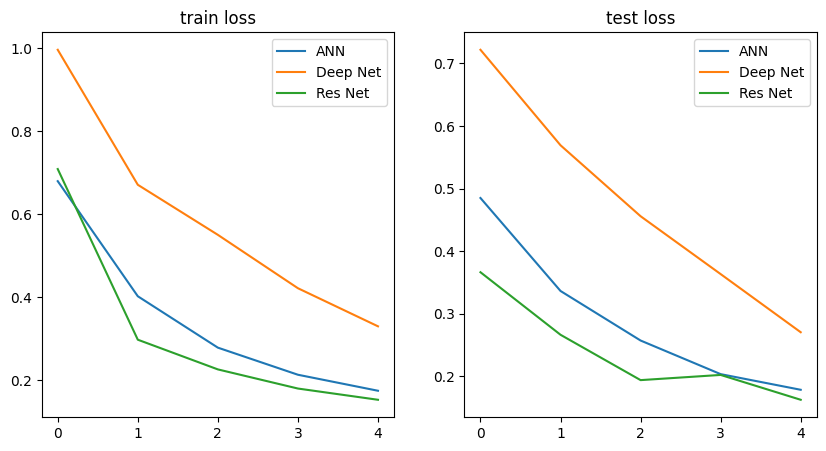

In [77]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("train loss")
plt.plot(train_loss_ann,  label="ANN")
plt.plot(train_loss_deep, label="Deep Net")
plt.plot(train_loss_res,  label="Res Net")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("test loss")
plt.plot(test_loss_ann,  label="ANN")
plt.plot(test_loss_deep, label="Deep Net")
plt.plot(test_loss_res,  label="Res Net")
plt.legend()